In [1]:
from icecream import ic

import numpy as np
import pandas as pd
from scipy.linalg import block_diag
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from stareg import Bspline, utils
import pprint

import plotly.graph_objects as go
import plotly.express as px
import time

MEEEE and Moooooo and asdasdasd


In [8]:
class stareg():
    
    def __init__(self):
        print("Class initialization")
        self.BS = Bspline()
        
    def fit(self,description, X, y):
        model = self.create_model_from_description(description, X, y)

        iterIdx = 1
        B = self.create_basis_matrix(model)
        S = self.create_smoothness_matrix(model)
        K = self.create_constraint_matrix(model)

        BtB = B.T @ B
        Bty = B.T @ y

        weights_compare, model = check_constraint_full_model(model)
        weights_old = dict()

        while not weights_compare == weights_old:
            weights_old = weights_compare
            coef_cpls = np.linalg.pinv(BtB + S + K) @ Bty
            weights_compare, model = check_constraint_full_model(model, coef=coef_cpls)

            print(f"Iteration {iterIdx}".center(50, "="))
            print(f"MSE: {mean_squared_error(y, B @ coef_cpls)}".center(50, " "))

            # need 
            K = self.create_constraint_matrix(model)
            time.sleep(1)
            iterIdx += 1
            if iterIdx > 15:
                print("Stop the count!")
                break

        print("".center(50, "="))
        print("Iteration Finished!".center(50,"-"))
        print("".center(50, "="))

        return dict(coef_=coef_cpls, B=B, S=S, K=K, model=model)
        
    def predict(self, Xpred, model, coef_):
        """Calculate the predictions for Xpred and the given model and coef_.
        
        Parameters:
        -----------
        Xpred : array    - Input data to calculate the predictions for.
        model : dict     - Model dictionary.
        coef_ : array    - Coefficients of the constraint B-splines.
        
        Returns:
        --------
        ypred : array     - Predicted values.
        basis : matrix    - B-spline basis matrix for the model.
        """
        
        basis = []
        for submodel in model.keys():
            type_ = model[submodel]["type"]
            nr_splines = model[submodel]["nr_splines"]
            knot_types = model[submodel]["knot_type"]
            order = model[submodel]["order"]
            print("Process ", type_)
            #time.sleep(0.2)
            if type_.startswith("s"):
                dim = int(type_[2])-1
                data = Xpred[:,dim]
                B = self.BS.basismatrix(X=data, nr_splines=nr_splines, l=order, knot_type=knot_types)["basis"]
            elif type_.startswith("t"):
                dim1, dim2 = int(type_[2])-1, int(type_[4])-1
                data = Xpred[:,[dim1, dim2]]
                B = self.BS.tensorproduct_basismatrix(X=data, nr_splines=nr_splines, l=order, knot_type=knot_types)["basis"]
            else:
                print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            basis.append(B)

        # create combined basis matrix
        B = np.concatenate(basis, axis=1)
        y = B @ coef_

        return dict(ypred=y, basis=B)


        
    def create_model_from_description(self, description, X, y):
        model = dict()
        parameter = ("type", "nr_splines", "constraint", "lambda_c", "knot_type")
        for idx, submodel in enumerate(description):
            model[f"f{idx+1}"] = dict()
            for type_and_value in zip(parameter, submodel):
                model[f"f{idx+1}"][type_and_value[0]] = type_and_value[1]
        #pprint.pprint(model) 
        for submodel in model:
            for key in model[submodel].keys():
                if key == "type":
                    type_ = model[submodel][key]
                    nr_splines = model[submodel]["nr_splines"]
                    knot_type = model[submodel]["knot_type"]
                    constraint = model[submodel]["constraint"]
                    lambda_c = model[submodel]["lambda_c"]
                    if type_.startswith("s"):
                        dim = int(type_[2])-1
                        data = X[:,dim]
                        order = 3
                        B, knots = self.BS.basismatrix(X=data, nr_splines=nr_splines, l=order, knot_type=knot_type).values()
                        Ds = utils.mm(nr_splines, constraint="smooth")
                        Dc = utils.mm(nr_splines, constraint=constraint)
                        lam = self.BS.calc_GCV(data, y, nr_splines=nr_splines, l=order, knot_type=knot_type, nr_lam=100, plot_=0)["best_lambda"]
                        coef_pls = self.BS.fit_Pspline(data, y, nr_splines=nr_splines, l=order, knot_type=knot_type, lam=lam)["coef_"]
                        W = utils.check_constraint(coef_pls, constraint, y=y, B=B)
                    elif type_.startswith("t"):
                        dim = [int(type_[2])-1,  int(type_[4])-1]
                        data = X[:,[dim[0],dim[1]]]
                        order = (3,3)
                        B, knots1, knots2 = self.BS.tensorproduct_basismatrix(X=data, nr_splines=nr_splines, l=order, knot_type=knot_type).values()
                        Ds1 = utils.mm(nr_splines, constraint="smooth", dim=0)
                        Ds2 = utils.mm(nr_splines, constraint="smooth", dim=1)
                        Dc1 = utils.mm(nr_splines, constraint=constraint[0], dim=0)                
                        Dc2 = utils.mm(nr_splines, constraint=constraint[1], dim=1)                
                        lam = self.BS.calc_GCV_2d(data, y, nr_splines=nr_splines, l=order, knot_type=knot_type, nr_lam=100, plot_=0)["best_lambda"]
                        coef_pls = self.BS.fit_Pspline(data, y, nr_splines=nr_splines, l=order, knot_type=knot_type, lam=lam)["coef_"]
                        W1 = utils.check_constraint_dim1(coef_pls, constraint[0], nr_splines)
                        W2 = utils.check_constraint_dim2(coef_pls, constraint[1], nr_splines)

                        knots, Ds, Dc, W = dict(), dict(), dict(), dict()
                        knots["k1"], knots["k2"] = knots1, knots2
                        Ds["Ds1"], Ds["Ds2"] = Ds1, Ds2
                        Dc["Dc1"], Dc["Dc2"] = Dc1, Dc2
                        W["v1"], W["v2"] = W1, W2

            model[submodel]["B"] = B
            model[submodel]["knots"] = knots
            model[submodel]["Ds"] = Ds
            model[submodel]["Dc"] = Dc
            model[submodel]["knots"] = knots
            model[submodel]["weights"] = W
            model[submodel]["coef_pls"] = coef_pls
            model[submodel]["best_lambda"] = lam
            model[submodel]["order"] = order

        return model

           
    def create_basis_matrix(self, model):
        B = []
        [B.append(model[submodel]["B"]) for submodel in model.keys()]
        basis_matrix = np.concatenate(B,axis=1)
        ic(basis_matrix.shape)
        
        return basis_matrix
    
    def create_smoothness_matrix(self, model):
        Ds = []
        for submodel in model.keys():
            type_ = model[submodel]["type"]
            if type_.startswith("s"):
                Ds.append(model[submodel]["best_lambda"] * model[submodel]["Ds"].T @ model[submodel]["Ds"])
            elif type_.startswith("t"):
                Ds1 = model[submodel]["Ds"]["Ds1"]
                Ds2 = model[submodel]["Ds"]["Ds2"]
                Ds.append(model[submodel]["best_lambda"] * (Ds1.T@Ds1 + Ds2.T@Ds2))
        
        smoothness_matrix = block_diag(*Ds)
        ic(smoothness_matrix.shape)
        return smoothness_matrix
        
    def create_constraint_matrix(self, model):
        Dc = []
        for submodel in model.keys():
            type_ = model[submodel]["type"]
            if type_.startswith("s"):
                Dc.append(model[submodel]["lambda_c"] * model[submodel]["Dc"].T @ np.diag(model[submodel]["weights"]) @ model[submodel]["Dc"])               
            elif type_.startswith("t"):
                Dc1 = model[submodel]["Dc"]["Dc1"]
                Dc2 = model[submodel]["Dc"]["Dc2"]
                ic(Dc1.shape)
                ic(Dc2.shape)
                weights1 = np.diag(model[submodel]["weights"]["v1"])
                weights2 = np.diag(model[submodel]["weights"]["v2"])
                ic(weights1.shape)
                ic(weights2.shape)
                Dc.append(model[submodel]["lambda_c"][0]*(Dc1.T@weights1@Dc1) + model[submodel]["lambda_c"][1]*(Dc2.T@weights2@Dc2))

        constraint_matrix = block_diag(*Dc)        
        ic(constraint_matrix.shape)
        
        return constraint_matrix
    
    def create_coef_vector(self, model):
        coef = []
        [list(coef.append(model[submodel]["coef_pls"])) for submodel in model.keys()]
        ic(coef.shape)
        
        return coef
    
    def calc_edof(self, B, S, K):
        """Calculates the effective degree of freedom according to Fahrmeir, Regression 2013, p.475.
        
        Parameters:
        -----------
        B : matrix     - Basis matrix of the model.
        S : matrix     - Smoothness penalty matrix of the model, aka. lam_s * D_2.T @ D_2.
        K : matrix     - Constraint penalty matrix of the model, aka. lam_c * D_c.T @ D_c.
        
        Returns:
        --------
        edof : float   - Effective degree of freedom.
        """
        BtB = B.T @ B
        edof = np.trace(BtB @ np.linalg.pinv(BtB + S + K))
        return edof
        
        
              
def check_constraint_full_model(model, coef=None, basis=0, y=0):
    """ Tests the whole model against all constraints given in the model.
    
    Parameters:
    ----------
    model : dict    - Model dictionary, output from stareg.create_model_from_description.
    coef : array    - If None, uses coef_pls as test coefficients.
    basis : matrix  - Basis matrix to evaluate peak/valley constraint.
    y : arra        - Target data to evaluate peak/valley constraint
    Returns:
    --------
    W : dict        - Keys are the submodels, values are the weight vectors of the submodel.
    model : dict    - Updated model, the weights are changed to be consisted with W.
    
    """
    W = dict()
    coef_idx = 0
    for submodel in model.keys():
        type_ = model[submodel]["type"]
        len_submodel = len(model[submodel]["coef_pls"])
        if coef is not None:
            test_coef = coef[coef_idx:len_submodel+coef_idx]
            #ic(test_coef.shape)
        else:
            test_coef = model[submodel]["coef_pls"]
        test_constraints = model[submodel]["constraint"]
        #ic(test_constraints)
        if type_.startswith("s"):
            v = list(utils.check_constraint(test_coef, constraint=test_constraints, y=y, B=model[submodel]["B"]))
            
        elif type_.startswith("t"):
            v1 = list(utils.check_constraint_dim1(test_coef, test_constraints[0], nr_splines=model[submodel]["nr_splines"]))
            v2 = list(utils.check_constraint_dim2(test_coef, test_constraints[1], nr_splines=model[submodel]["nr_splines"]))
            v = dict(v1=v1, v2=v2)
        
        model[submodel]["weights"] = v
        W[submodel] = v
        coef_idx += len_submodel
        #ic(coef_idx)
    return W, model

### Create some 1D test data

In [25]:
np.random.seed(2)

n_data = 1000
x = np.random.rand(n_data)
ytrue = np.sin(6*x) + 4*x**2
y = ytrue + np.random.normal(scale=0.1, size=n_data)

df = pd.DataFrame(data=dict(x=x, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)

Xtrain = df_train[["x"]].values.reshape((-1,1))
ytrain = df_train[["y"]].values.ravel()

In [10]:
description = ( ("s(1)", 100, "inc", 10000, "e"), )

### Create the test model

In [11]:
star_model = stareg()

Class initialization


In [12]:
res = star_model.fit(description, Xtrain, ytrain)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 211.86it/s]
ic| basis_matrix.shape: (750, 100)
ic| smoothness_matrix.shape: (100, 100)
ic| constraint_matrix.shape: (100, 100)
ic| constraint_matrix.shape: (100, 100)


===================Iteration 1====================
            MSE: 0.014791352713029343             


ic| constraint_matrix.shape: (100, 100)


===================Iteration 2====================
            MSE: 0.015740738014684136             
---------------Iteration Finished!----------------


In [13]:
star_model.calc_edof(B=res["B"], S=res["S"], K=res["K"])

In [26]:
df_train.head()

,x,y,ytrue
218,0.569141,1.053593,1.025821
718,0.160212,0.913870,0.922594
28,0.220306,1.232327,1.163309
356,0.002482,-0.101534,0.014919
110,0.263779,1.111548,1.278246


In [27]:
df_train["ypred"] = res["B"]@res["coef_"]

C:\Users\jakob\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



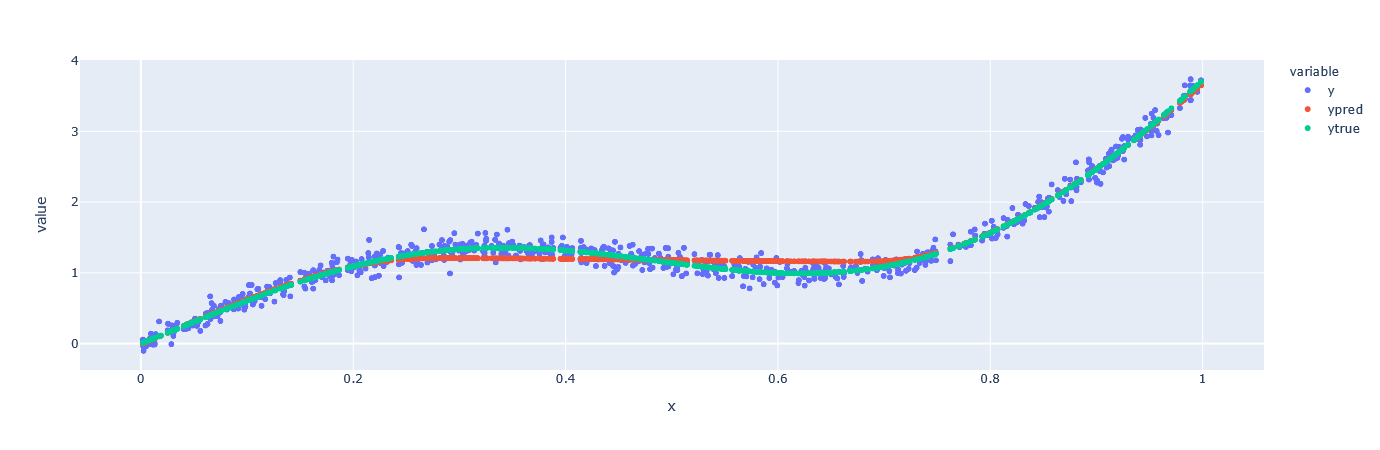

In [29]:
px.scatter(data_frame=df_train, x="x", y=["y", "ypred", "ytrue"])

### Create some 2d test data

In [15]:
np.random.seed(2)

n_data = 1000
x1 = np.random.rand(n_data)
x2 = np.random.rand(n_data)

ytrue = np.sin(6*x1) + 4*x2**2
y = ytrue + np.random.normal(scale=0.1, size=n_data)


df = pd.DataFrame(data=dict(x1=x1, x2=x2, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)

Xtrain = df_train[["x1", "x2"]].values
ytrain = df_train[["y"]].values.ravel()

### Test 2d spline model

In [23]:
description = ( ("s(1)", 100, "none", 6000, "e"),
                ("s(2)", 100, "inc", 6000, "e"),
                )

Create test model

In [24]:
M2d = stareg()

res2d = M2d.fit(description, Xtrain, ytrain)

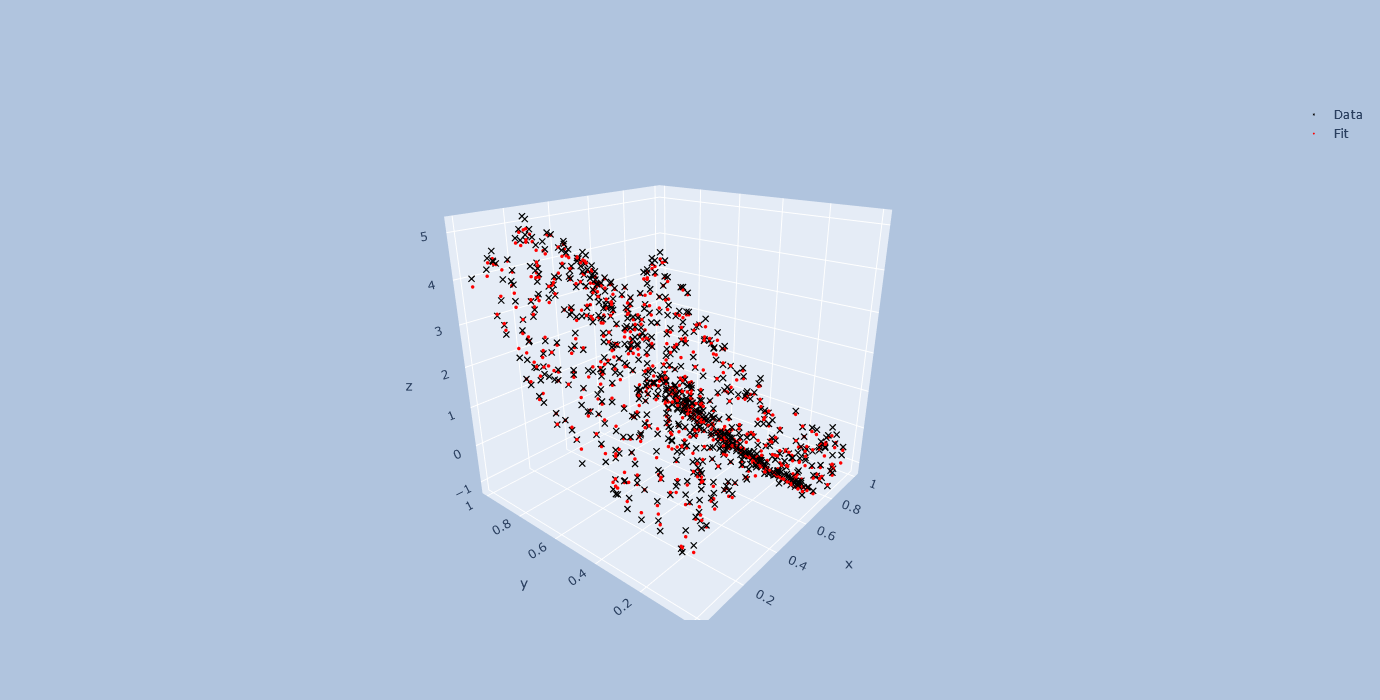

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df_train["x1"], y=df_train["x2"], z=df_train["y"], name="Data", mode="markers", marker=dict(size=2, color="black", symbol="x")))
fig.add_trace(go.Scatter3d(x=df_train["x1"], y=df_train["x2"], z=res2d["B"]@res2d["coef"], name="Fit", mode="markers", marker=dict(size=2, color="red", symbol="circle")))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    paper_bgcolor="LightSteelBlue",
)

### Test 2d spline model with tensorporduct spliens

In [36]:
np.random.seed(2)

n_data = 1000
x1 = np.random.rand(n_data)
x2 = np.random.rand(n_data)

ytrue = np.sin(6*x1) + 4*x2**2 - x1*x2
y = ytrue + np.random.normal(scale=0.1, size=n_data)


df = pd.DataFrame(data=dict(x1=x1, x2=x2, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)

Xtrain = df_train[["x1", "x2"]].values
ytrain = df_train[["y"]].values.ravel()

In [37]:
description = ( ("s(1)", 100, "none", 6000, "e"),
                ("s(2)", 100, "inc", 6000, "e"),
                ("t(1,2)", (12,8), ("none", "inc"), (0,6000), ("e","e")),
              )

In [38]:
M2d_with_tps = stareg()

res2d_with_tps = M2d_with_tps.fit(description, Xtrain, ytrain)

 21%|██████████████████████████████████▏                                                                                                                                | 21/100 [00:00<00:00, 205.84it/s]

Class initialization


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 217.82it/s]
ic| basis_matrix.shape: (750, 296)
ic| smoothness_matrix.shape: (296, 296)
ic| Dc1.shape: (96, 96)
ic| Dc2.shape: (84, 96)
ic| weights1.shape: (96, 96)
ic| weights2.shape: (84, 84)
ic| constraint_matrix.shape: (296, 296)
ic| Dc1.shape: (96, 96)
ic| Dc2.shape: (84, 96)
ic| weights1.shape: (96, 96)
ic| weights2.shape: (84, 84)
ic| constraint_matrix.shape: (296, 296)


===================Iteration 1====================
            MSE: 0.009378722081397551             


ic| Dc1.shape: (96, 96)
ic| Dc2.shape: (84, 96)
ic| weights1.shape: (96, 96)
ic| weights2.shape: (84, 84)
ic| constraint_matrix.shape: (296, 296)


===================Iteration 2====================
             MSE: 0.00942945420247474             


ic| Dc1.shape: (96, 96)
ic| Dc2.shape: (84, 96)
ic| weights1.shape: (96, 96)
ic| weights2.shape: (84, 84)
ic| constraint_matrix.shape: (296, 296)


===================Iteration 3====================
            MSE: 0.009449430402925875             


ic| Dc1.shape: (96, 96)
ic| Dc2.shape: (84, 96)
ic| weights1.shape: (96, 96)
ic| weights2.shape: (84, 84)
ic| constraint_matrix.shape: (296, 296)


===================Iteration 4====================
            MSE: 0.009449459046889696             
---------------Iteration Finished!----------------


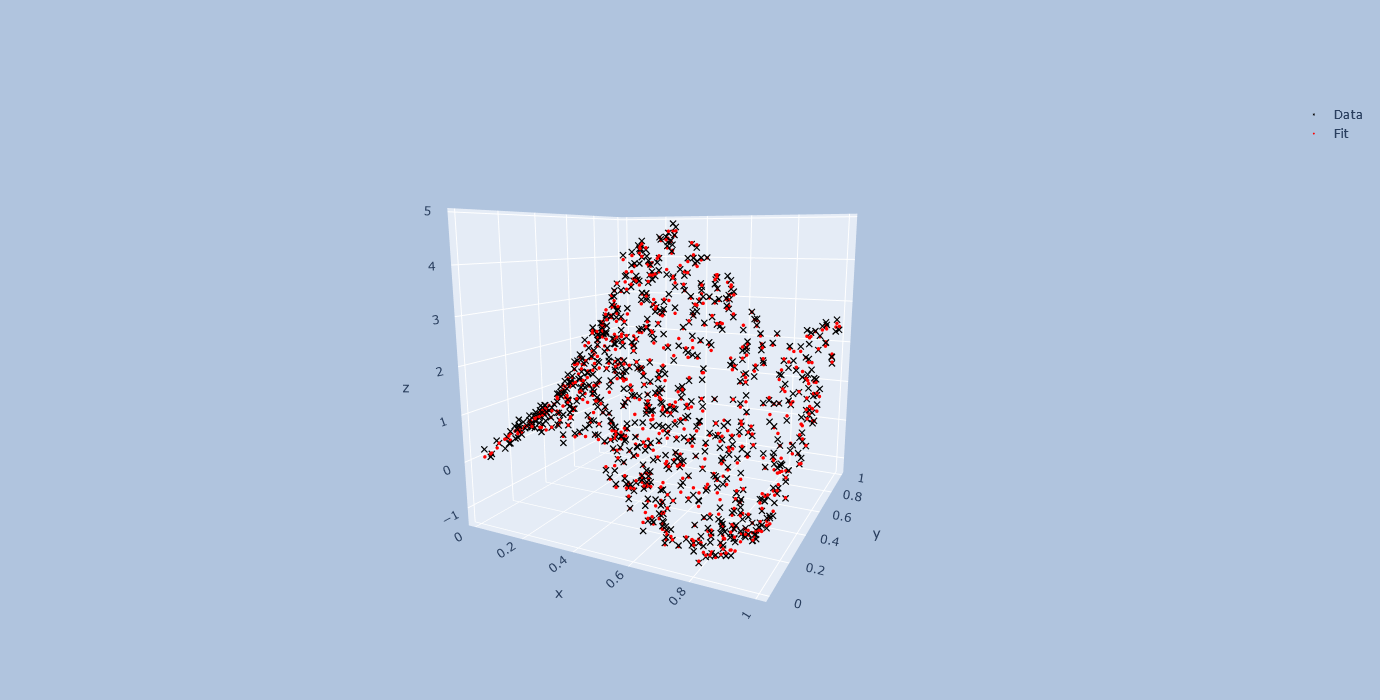

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df_train["x1"], y=df_train["x2"], z=df_train["y"], name="Data", mode="markers", marker=dict(size=2, color="black", symbol="x")))
fig.add_trace(go.Scatter3d(x=df_train["x1"], y=df_train["x2"], z=res2d_with_tps["B"]@res2d_with_tps["coef"], name="Fit", mode="markers", marker=dict(size=2, color="red", symbol="circle")))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    paper_bgcolor="LightSteelBlue",
)

# **Bosch Data**

In [30]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import scipy.io
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from stareg import Bspline

In [31]:
np.random.seed(2)
data_path = Path("../../Master-Thesis/Data/2021_01_21_DatenEHS")
inputs = ["shd", "qpd"]
os.listdir(data_path)

['forceMapMeas_Multsin.mat',
 'forceMapMod_Multsin.mat',
 'forceMapSynth_Test.mat',
 'forceMapSynth_Train.mat',
 'forceMapSynth_Vali.mat',
 'readme.md']

In [32]:
def file_to_df(fname):
    mat = scipy.io.loadmat(data_path/fname)
    df = pd.DataFrame(data=dict(shd=mat["shd"].ravel(), qpd=mat["qpd"].ravel(), Imag=mat["Imag"].ravel(), Fmagd=mat["Fmagd"].ravel()))
    return df

## Load Data (Measurments) and perform min-max-scaling

In [33]:
#df = file_to_df("forceMapMeas_Multsin.mat")
df = file_to_df("forceMapSynth_Train.mat")
x = df[inputs].values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_df = pd.DataFrame(np.hstack((x_scaled, df["Imag"].values.reshape(-1,1))), columns=inputs+["Imag"])

## Train-Test Split

In [34]:
train_df, test_df = train_test_split(scaled_df)
Xtrain, ytrain = train_df[["shd", "qpd"]].values, train_df["Imag"].values
Xtest, ytest = test_df[["shd", "qpd"]].values, test_df["Imag"].values

Xtrain.shape, ytrain.shape, "\t", Xtest.shape, ytest.shape

((750, 2), (750,), '\t', (250, 2), (250,))

## Plot Data

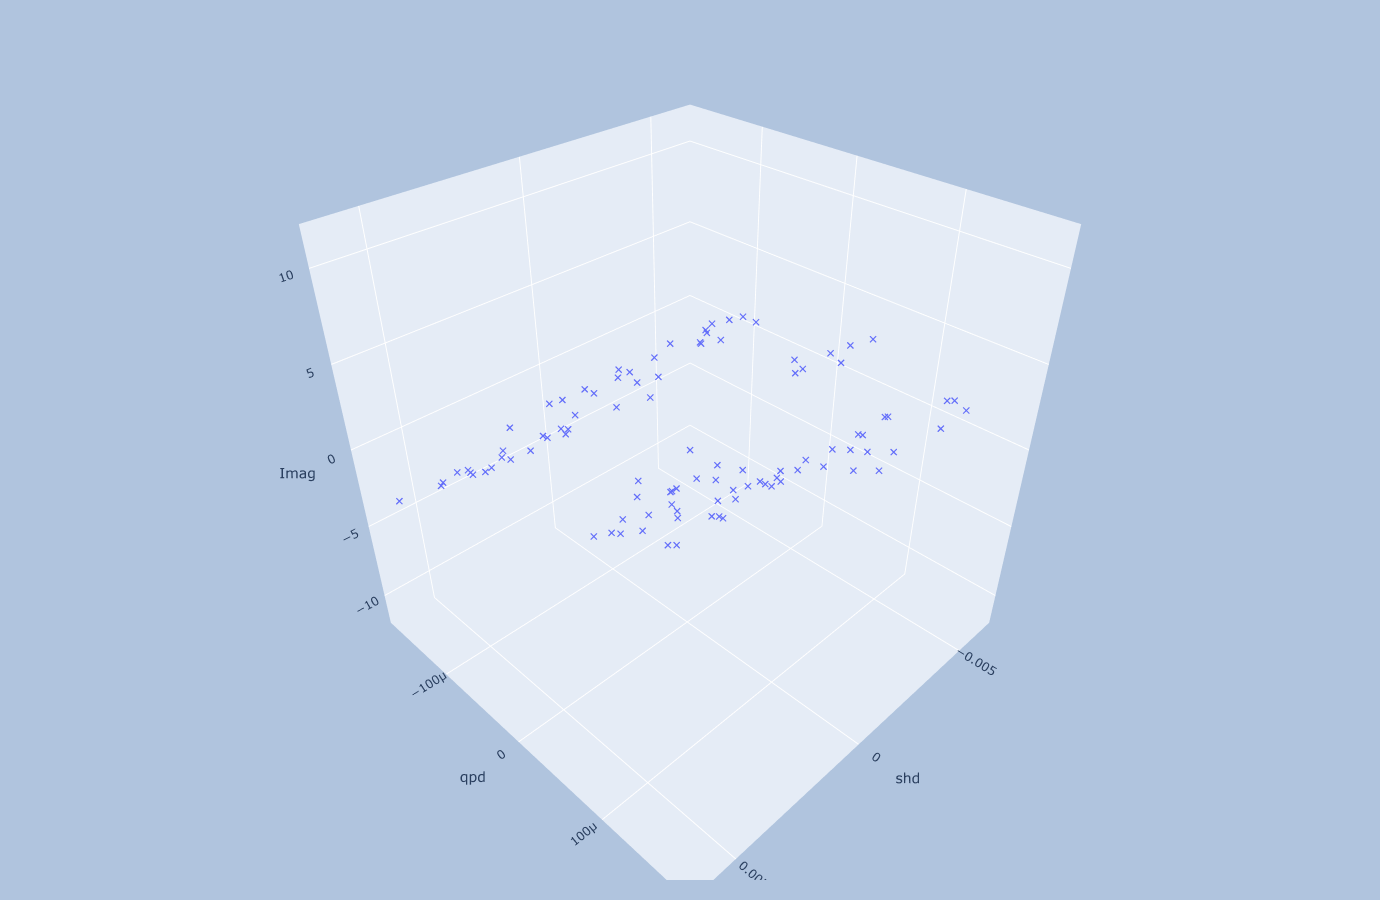

In [35]:
plot_i = 10
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df["shd"][::plot_i], y=df["qpd"][::plot_i], z=df["Fmagd"][::plot_i], name="Data", mode="markers", marker=dict(size=2, symbol="x")))

fig.update_layout(
    scene=dict(xaxis_title="shd", yaxis_title="qpd", zaxis_title="Imag"),
    autosize=False,
    width=1400,
    height=900,
    paper_bgcolor="LightSteelBlue",
    margin=dict(l=20, r=20, t=20, b=20),
)

## Generate the model descriptions

In [36]:
model_list =["s1s2_WC", "s1s2", "t12_WC", "t12", "tot_WC", "tot"]
m_s1s2_without_constrait =  (("s(1)", 100, "none", 0, "e"), 
                             ("s(2)", 100, "none", 0, "e"), )
m_s1s2 = (("s(1)", 100, "none", 1000, "e"), 
          ("s(2)", 100, "inc", 6000, "e"), )

m_t12_without_constraint = (("t(1,2)", (30,10), ("none", "none"), (0,0), ("e", "e")), )
m_t12 = (("t(1,2)", (30,10), ("inc", "inc"), (6000,6000), ("e", "e")), )

m_tot_without_constraint = ( #("s(1)", 100, "none", 0, "e"), 
                             ("s(2)", 100, "none", 0, "e"),
                             ("t(1,2)", (20,10), ("none", "none"), (0,0), ("e", "e")), )
m_tot = ( #("s(1)", 100, "none", 1000, "e"), 
          ("s(2)", 100, "inc", 1000, "e"),
          ("t(1,2)", (30,10), ("inc", "inc"), (6000,6000), ("e", "e")), )

## Fit the models

In [37]:
STAREG = stareg()

Class initialization


In [38]:
M1 = STAREG.fit(m_s1s2_without_constrait, Xtrain, ytrain)
M2 = STAREG.fit(m_s1s2, Xtrain, ytrain)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 223.05it/s]
ic| basis_matrix.shape: (750, 200)
ic| smoothness_matrix.shape: (200, 200)
ic| constraint_matrix.shape: (200, 200)
ic| constraint_matrix.shape: (200, 200)


===================Iteration 1====================
            MSE: 0.024239824639415354             


 24%|███████████████████████████████████████                                                                                                                            | 24/100 [00:00<00:00, 228.66it/s]

---------------Iteration Finished!----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 215.88it/s]
ic| basis_matrix.shape: (750, 200)
ic| smoothness_matrix.shape: (200, 200)
ic| constraint_matrix.shape: (200, 200)
ic| constraint_matrix.shape: (200, 200)


===================Iteration 1====================
             MSE: 0.02453032400874694             


ic| constraint_matrix.shape: (200, 200)


===================Iteration 2====================
            MSE: 0.024277362408982286             


ic| constraint_matrix.shape: (200, 200)


===================Iteration 3====================
            MSE: 0.024239824639415354             
---------------Iteration Finished!----------------


In [39]:
M3 = STAREG.fit(m_t12_without_constraint, Xtrain, ytrain)
M4 = STAREG.fit(m_t12, Xtrain, ytrain)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.27it/s]
ic| basis_matrix.shape: (750, 300)
ic| smoothness_matrix.shape: (300, 300)
ic| Dc1.shape: (300, 300)
ic| Dc2.shape: (300, 300)
ic| weights1.shape: (300, 300)
ic| weights2.shape: (300, 300)
ic| constraint_matrix.shape: (300, 300)
ic| Dc1.shape: (300, 300)
ic| Dc2.shape: (300, 300)
ic| weights1.shape: (300, 300)
ic| weights2.shape: (300, 300)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 1====================
            MSE: 0.0027381431025959736            


  3%|████▉                                                                                                                                                                | 3/100 [00:00<00:03, 27.29it/s]

---------------Iteration Finished!----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.63it/s]
ic| basis_matrix.shape: (750, 300)
ic| smoothness_matrix.shape: (300, 300)
ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)
ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 1====================
            MSE: 0.004036727680680996             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 2====================
            MSE: 0.004065535874381947             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 3====================
            MSE: 0.004177743774896094             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 4====================
             MSE: 0.00421876116032522             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 5====================
            MSE: 0.004249092179922009             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 6====================
            MSE: 0.004202477729615392             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 7====================
            MSE: 0.004229098150054383             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 8====================
            MSE: 0.004240038240306186             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 9====================
            MSE: 0.004248541697845169             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 10===================
            MSE: 0.004247440704934842             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 11===================
            MSE: 0.004258172917088089             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 12===================
             MSE: 0.00426423630115556             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 13===================
            MSE: 0.004264767757380389             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 14===================
            MSE: 0.004265057333825361             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 15===================
            MSE: 0.004265052729614894             
Stop the count!
---------------Iteration Finished!----------------


In [40]:
M5 = STAREG.fit(m_tot_without_constraint, Xtrain, ytrain)
M6 = STAREG.fit(m_tot, Xtrain, ytrain)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.51it/s]
ic| basis_matrix.shape: (750, 300)
ic| smoothness_matrix.shape: (300, 300)
ic| Dc1.shape: (200, 200)
ic| Dc2.shape: (200, 200)
ic| weights1.shape: (200, 200)
ic| weights2.shape: (200, 200)
ic| constraint_matrix.shape: (300, 300)
ic| Dc1.shape: (200, 200)
ic| Dc2.shape: (200, 200)
ic| weights1.shape: (200, 200)
ic| weights2.shape: (200, 200)
ic| constraint_matrix.shape: (300, 300)


===================Iteration 1====================
            MSE: 0.003964983675931775             


 22%|███████████████████████████████████▊                                                                                                                               | 22/100 [00:00<00:00, 215.02it/s]

---------------Iteration Finished!----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.46it/s]
ic| basis_matrix.shape: (750, 400)
ic| smoothness_matrix.shape: (400, 400)
ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)
ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 1====================
            MSE: 0.003539913599868893             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 2====================
            MSE: 0.003829764192948096             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 3====================
            MSE: 0.003923450833767695             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 4====================
            MSE: 0.003956283125533793             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 5====================
            MSE: 0.003997649022306715             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 6====================
            MSE: 0.0040198386250467405            


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 7====================
            MSE: 0.004039422053157357             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 8====================
            MSE: 0.0040483861665737845            


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 9====================
            MSE: 0.004050411682547672             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 10===================
            MSE: 0.004058786078314059             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 11===================
            MSE: 0.004059882557996229             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 12===================
            MSE: 0.004059909007971418             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 13===================
            MSE: 0.004059611677719888             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 14===================
            MSE: 0.004057450532695195             


ic| Dc1.shape: (290, 300)
ic| Dc2.shape: (270, 300)
ic| weights1.shape: (290, 290)
ic| weights2.shape: (270, 270)
ic| constraint_matrix.shape: (400, 400)


===================Iteration 15===================
            MSE: 0.004058249786464098             
Stop the count!
---------------Iteration Finished!----------------


## Calculate Predictions on Test Data

In [41]:
M1pred = STAREG.predict(Xpred=Xtest, model=M1["model"], coef_=M1["coef_"])
M2pred = STAREG.predict(Xpred=Xtest, model=M2["model"], coef_=M2["coef_"])
M3pred = STAREG.predict(Xpred=Xtest, model=M3["model"], coef_=M3["coef_"])
M4pred = STAREG.predict(Xpred=Xtest, model=M4["model"], coef_=M4["coef_"])
M5pred = STAREG.predict(Xpred=Xtest, model=M5["model"], coef_=M5["coef_"])
M6pred = STAREG.predict(Xpred=Xtest, model=M6["model"], coef_=M6["coef_"])

Process  s(1)
Process  s(2)
Process  s(1)
Process  s(2)
Process  t(1,2)
Process  t(1,2)
Process  s(2)
Process  t(1,2)
Process  s(2)
Process  t(1,2)


## MSE & EDoF on Test Data

In [67]:
MSE_M1, edof_M1 = mean_squared_error(ytest, M1pred["ypred"]), STAREG.calc_edof(B=M1["B"], S=M1["S"], K=M1["K"]).round(3)
MSE_M2, edof_M2 = mean_squared_error(ytest, M2pred["ypred"]), STAREG.calc_edof(B=M2["B"], S=M2["S"], K=M2["K"]).round(3)
MSE_M3, edof_M3 = mean_squared_error(ytest, M3pred["ypred"]), STAREG.calc_edof(B=M3["B"], S=M3["S"], K=M3["K"]).round(3)
MSE_M4, edof_M4 = mean_squared_error(ytest, M4pred["ypred"]), STAREG.calc_edof(B=M4["B"], S=M4["S"], K=M4["K"]).round(3)
MSE_M5, edof_M5 = mean_squared_error(ytest, M5pred["ypred"]), STAREG.calc_edof(B=M5["B"], S=M5["S"], K=M5["K"]).round(3)
MSE_M6, edof_M6 = mean_squared_error(ytest, M6pred["ypred"]), STAREG.calc_edof(B=M6["B"], S=M6["S"], K=M6["K"]).round(3)

r, lj = 8, 14
print("".center(50,"="))
print("MSEs on Validation Data".center(50, " "))
print("".center(50,"="))
print(f"{model_list[0]}-MSE = ".ljust(lj), MSE_M1, " EDoF: ".rjust(r, "|"), edof_M1)
print(f"{model_list[1]}-MSE = ".ljust(lj), MSE_M2, " EDoF: ".rjust(r, "|"), edof_M2)
print(f"{model_list[2]}-MSE = ".ljust(lj), MSE_M3, " EDoF: ".rjust(r, "|"), edof_M3)
print(f"{model_list[3]}-MSE = ".ljust(lj), MSE_M4, " EDoF: ".rjust(r, "|"), edof_M4)
print(f"{model_list[4]}-MSE = ".ljust(lj), MSE_M5, " EDoF: ".rjust(r, "|"), edof_M5)
print(f"{model_list[5]}-MSE = ".ljust(lj), MSE_M6, " EDoF: ".rjust(r, "|"), edof_M6)

             MSEs on Validation Data              
s1s2_WC-MSE =  0.026486367173401203 | EDoF:  30.071
s1s2-MSE =     0.026486367173401203 | EDoF:  30.071
t12_WC-MSE =   0.004205062939413304 | EDoF:  165.902
t12-MSE =      0.004835824311466111 | EDoF:  31.144
tot_WC-MSE =   0.005866916469890019 | EDoF:  122.475
tot-MSE =      0.004681798983547745 | EDoF:  33.863


## Plot model 4 and model 6

Process  t(1,2)
Process  s(2)
Process  t(1,2)


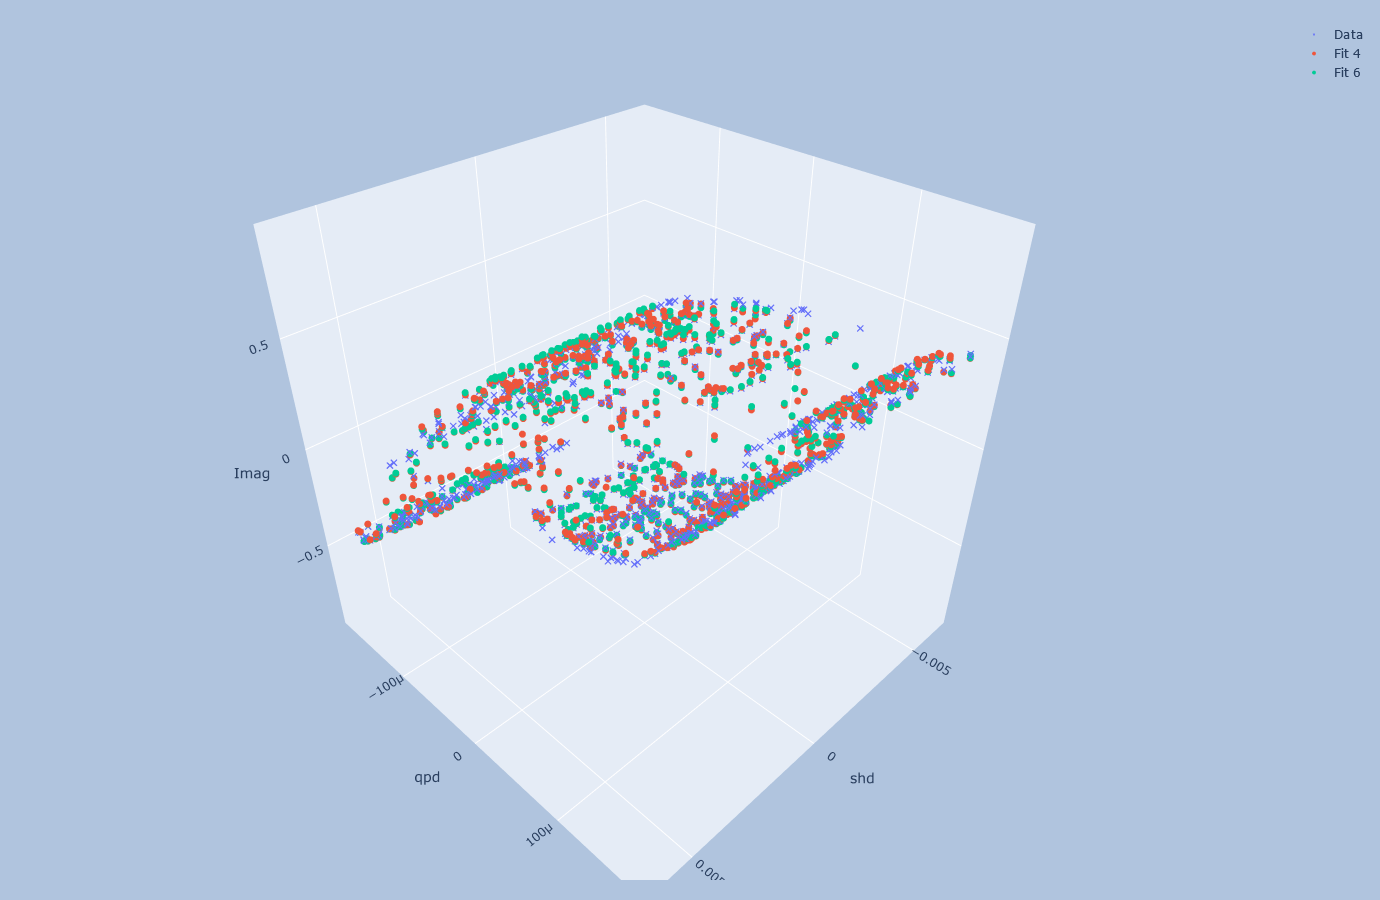

In [68]:
M4__ = STAREG.predict(Xpred=df[inputs].values, model=M4["model"], coef_=M4["coef_"])
M6__ = STAREG.predict(Xpred=df[inputs].values, model=M6["model"], coef_=M6["coef_"])


plot_i = 1
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df["shd"][::plot_i], y=df["qpd"][::plot_i], z=df["Imag"][::plot_i], name="Data", mode="markers", marker=dict(size=2, symbol="x")))
fig.add_trace(go.Scatter3d(x=df["shd"][::plot_i], y=df["qpd"][::plot_i], z=M4__["ypred"][::plot_i], name="Fit 4", mode="markers",marker=dict(size=4, symbol="circle")))
fig.add_trace(go.Scatter3d(x=df["shd"][::plot_i], y=df["qpd"][::plot_i], z=M6__["ypred"][::plot_i], name="Fit 6", mode="markers",marker=dict(size=4, symbol="circle")))

fig.update_layout(
    scene=dict(xaxis_title="shd", yaxis_title="qpd", zaxis_title="Imag"),
    autosize=False,
    width=1400,
    height=900,
    paper_bgcolor="LightSteelBlue",
    margin=dict(l=20, r=20, t=20, b=20),
)